In [1]:
import warnings
warnings.filterwarnings('ignore')

# 0. Start PySpark

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('project').getOrCreate()
spark

In [4]:
df = spark.read.format('csv').option('header', 'true').load('s3://pubg-proj/*.csv')

In [5]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- game_size: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: string (nullable = true)
 |-- player_assists: string (nullable = true)
 |-- player_dbno: string (nullable = true)
 |-- player_dist_ride: string (nullable = true)
 |-- player_dist_walk: string (nullable = true)
 |-- player_dmg: string (nullable = true)
 |-- player_kills: string (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: string (nullable = true)
 |-- team_id: string (nullable = true)
 |-- team_placement: string (nullable = true)



In [6]:
print(f'Number of Rows: {df.count()}')
print(f'Number of Cols: {len(df.columns)}')

Number of Rows: 67369231
Number of Cols: 15


In [7]:
df.limit(5).toPandas()

,date,game_size,match_id,match_mode,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_name,player_survive_time,team_id,team_placement
0,2018-01-03T03:50:46+0000,28,2U4GBNA0YmloOiz1tP_mmlhLY97uP6Yg1KcSgCTWGZkugX...,tpp,4,0,1,2547.8234899999998,1070.20911,82,1,Level99Bard,803.434,10,21
1,2018-01-03T03:50:46+0000,28,2U4GBNA0YmloOiz1tP_mmlhLY97uP6Yg1KcSgCTWGZkugX...,tpp,4,0,0,0.0,85.77402,81,0,Burnem2,161.94299999999998,11,15
2,2018-01-03T03:50:46+0000,28,2U4GBNA0YmloOiz1tP_mmlhLY97uP6Yg1KcSgCTWGZkugX...,tpp,4,0,0,0.0,3040.82178,0,0,CLITORI_HUNTER,1352.7320000000002,11,15
3,2018-01-03T03:50:46+0000,28,2U4GBNA0YmloOiz1tP_mmlhLY97uP6Yg1KcSgCTWGZkugX...,tpp,4,0,0,0.0,349.8995,0,0,wudidexiaohaizio,242.855,11,15
4,2018-01-03T03:50:46+0000,28,2U4GBNA0YmloOiz1tP_mmlhLY97uP6Yg1KcSgCTWGZkugX...,tpp,4,0,0,0.0,121.67002099999999,0,0,Uniapple,146.97,11,15


## Change DataType

In [5]:
import pyspark.sql.functions as F
df = df.withColumn('date',  F.to_timestamp('date',  "yyyy-MM-dd'T'HH:mm:ssZ"))

In [6]:
df = df.withColumn('game_size', df['game_size'].cast('int'))
df = df.withColumn('party_size', df['party_size'].cast('int'))
df = df.withColumn('player_assists', df['player_assists'].cast('int'))
df = df.withColumn('player_dbno', df['player_dbno'].cast('int'))
df = df.withColumn('player_dmg', df['player_dmg'].cast('int'))
df = df.withColumn('player_kills', df['player_kills'].cast('int'))
df = df.withColumn('team_placement', df['team_placement'].cast('int'))

In [7]:
df = df.withColumn('player_dist_ride', df['player_dist_ride'].cast('float'))
df = df.withColumn('player_dist_walk', df['player_dist_walk'].cast('float'))
df = df.withColumn('player_survive_time', df['player_survive_time'].cast('float'))

## Define Match Type

In [8]:
df = df.withColumn('team_type', F.when(F.col('party_size') == 1, 'solo')\
                   .otherwise(F.when(F.col('party_size') == 2, 'duo')\
                              .otherwise('squad')))

## Define Team Placement Percentile and Bin

In [9]:
df = df.withColumn('place_perc', df['team_placement']/df['game_size'])

In [10]:
from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits = [i/10 for i in range(0,11)], inputCol = 'place_perc', outputCol = 'place_bin')
df = bucketizer.setHandleInvalid('keep').transform(df)

In [11]:
from pyspark.sql.types import *

labels = {0.0:'top10%', 1.0:'10~20%', 2.0:'20~30%',
          3.0:'30~40%', 4.0:'40~50%', 5.0:'50~60%',
          6.0:'60~70%', 7.0:'70~80%', 8.0:'80~90%', 9.0:'last10%'}
udf = F.udf(lambda x: labels[x], StringType())
df = df.withColumn('place_bin_label', udf('place_bin'))

## Whether the Player Drove

In [12]:
df = df.withColumn("drive", F.when(F.col('player_dist_ride') > 0, 1)\
                                      .otherwise(0))

In [13]:
df.cache()
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: float (nullable = true)
 |-- player_dist_walk: float (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: float (nullable = true)
 |-- team_id: string (nullable = true)
 |-- team_placement: integer (nullable = true)
 |-- team_type: string (nullable = false)
 |-- place_perc: double (nullable = true)
 |-- place_bin: double (nullable = true)
 |-- place_bin_label: string (nullable = true)
 |-- drive: integer (nullable = false)



## Define Game Size

In [14]:
df = df.withColumn("game_size_catg", F.when(F.col('game_size') <= 31, "Small")\
                                      .when(F.col('game_size').between(32,60), "Medium")
                                      .otherwise("Large"))

In [15]:
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: float (nullable = true)
 |-- player_dist_walk: float (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: float (nullable = true)
 |-- team_id: string (nullable = true)
 |-- team_placement: integer (nullable = true)
 |-- team_type: string (nullable = false)
 |-- place_perc: double (nullable = true)
 |-- place_bin: double (nullable = true)
 |-- place_bin_label: string (nullable = true)
 |-- drive: integer (nullable = false)
 |-- game_size_catg: string (nullable = false)



## Whether the Player was in Top 5

In [15]:
df = df.withColumn('top_5', F.when(F.col('team_placement').between(1, 5), 1)\
                   .otherwise(0))

In [16]:
df = df.drop(*['date', 'party_size', 'player_name', 'team_id', 'match_mode', 'match_id'])

In [18]:
df.cache()
df.printSchema()

root
 |-- game_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: float (nullable = true)
 |-- player_dist_walk: float (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_survive_time: float (nullable = true)
 |-- team_placement: integer (nullable = true)
 |-- team_type: string (nullable = false)
 |-- place_perc: double (nullable = true)
 |-- place_bin: double (nullable = true)
 |-- place_bin_label: string (nullable = true)
 |-- drive: integer (nullable = false)
 |-- game_size_catg: string (nullable = false)
 |-- top_5: integer (nullable = false)



In [22]:
df.limit(5).toPandas()

,game_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_placement,team_type,place_perc,place_bin,place_bin_label,drive,game_size_catg,top_5
0,97,0,0,0.000000,2082.822998,0,0,661.491028,50,solo,0.515464,5.0,50~60%,0,Large,0
1,97,0,0,0.000000,1118.814941,0,0,741.359009,47,solo,0.484536,4.0,40~50%,0,Large,0
2,97,0,0,0.000000,25.533026,73,0,83.254997,97,solo,1.000000,9.0,last10%,0,Large,0
3,97,0,0,997.510010,1032.667847,345,3,1144.816040,30,solo,0.309278,3.0,30~40%,1,Large,0
4,97,0,0,4296.359375,2300.323486,449,4,1112.843018,32,solo,0.329897,3.0,30~40%,1,Large,0


In [19]:
target = 'top_5'
catg = 'team_type'
numr = ['player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills', 'player_count']
intg = ['player_assists', 'player_dbno', 'player_dmg', 'player_kills']
cont = ['player_dist_ride', 'player_dist_walk']

In [20]:
pip install handyspark

     |████████████████████████████████| 215kB 50.2MB/s eta 0:00:01
     |████████████████████████████████| 215.6MB 49.3MB/s eta 0:00:01     |███████████████████████████▎    | 183.6MB 44.6MB/s eta 0:00:01     |██████████████████████████████▊ | 206.8MB 49.3MB/s eta 0:00:01
     |████████████████████████████████| 204kB 47.9MB/s eta 0:00:01
  Stored in directory: /home/hadoop/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [21]:
from handyspark import *
hdf = df.toHandy()

In [22]:
df2 = df.withColumn('player_dist_ride', df['player_dist_ride'].cast('int'))
df2 = df2.withColumn('player_dist_walk', df['player_dist_walk'].cast('int'))
hdf2 = df2.toHandy()

## Basic Statistics for Numeric Features

In [23]:
import pandas as pd
summary = {'null_count': hdf.isnull()[intg+cont].tolist(),
           'mean'      : [round(val, 4) for val in hdf.cols[intg+cont].mean()],
           'stddev'    : [round(val, 4) for val in hdf.cols[intg+cont].stddev()],
           'min'       : hdf.cols[intg].min().tolist()    + [round(val, 1) for val in hdf.cols[cont].min().tolist()],
           'q1'        : hdf.cols[intg].q1().tolist()     + [round(val, 1) for val in hdf.cols[cont].q1().tolist()],
           'median'    : hdf.cols[intg].median().tolist() + [round(val, 1) for val in hdf.cols[cont].median().tolist()],
           'q3'        : hdf.cols[intg].q3().tolist()     + [round(val, 1) for val in hdf.cols[cont].q3().tolist()],
           'max'       : hdf.cols[intg].max().tolist()    + [round(val, 1) for val in hdf.cols[cont].max().tolist()],
           'mode'      : hdf.cols[intg].mode().tolist()   + [round(val, 1) for val in hdf.cols[cont].mode().tolist()]}

In [24]:
summary_pd = pd.DataFrame.from_dict(summary)
summary_pd1 = summary_pd.T

In [25]:
idx_names = ['player_assists', 'player_dbno', 'player_dmg', 'player_kills', 
             'player_dist_ride', 'player_dist_walk']
summary_pd1.columns = idx_names
summary_pd1.round(2)

,player_assists,player_dbno,player_dmg,player_kills,player_dist_ride,player_dist_walk
null_count,0.00,0.00,0.00,0.00,0.00,0.00
mean,0.23,0.58,123.94,0.89,1156.31,1284.10
stddev,0.58,1.12,169.49,1.55,1999.74,4210.94
min,0.00,0.00,0.00,0.00,0.00,0.00
q1,0.00,0.00,2.00,0.00,0.00,222.70
median,0.00,0.00,79.00,0.00,0.00,918.80
q3,0.00,1.00,179.00,1.00,2062.80,2116.70
max,13.00,148.00,9408.00,94.00,506175.40,1273645.40
mode,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
print ('{:<10} | {:<14} | {:<14} | {:<14} | {:<14} | {:<14} | {:<16} | {:<16}'.format(
    'stat', 'player_assists', 'player_dbno', 
    'player_dmg', 'player_kills', 'player_count', 
    'player_dist_ride', 'player_dist_walk', 'player_surv_time'))
print ("-"*133)
for k, v in summary.items():
    player_assists, player_dbno, player_dmg, player_kills, player_count, player_dist_ride, player_dist_walk = v
    print ('{:<10} | {:<14} | {:<14} | {:<14} | {:<14} | {:<14} | {:<16} | {:<16}'.format(
        k, player_assists, player_dbno, player_dmg, player_kills, player_count, player_dist_ride, player_dist_walk))

stat       | player_assists | player_dbno    | player_dmg     | player_kills   | player_count   | player_dist_ride | player_dist_walk
-------------------------------------------------------------------------------------------------------------------------------------
null_count | 0              | 0              | 0              | 0              | 0              | 0                | 0               
mean       | 0.2296         | 0.5844         | 123.9444       | 0.8873         | 100.3049       | 1156.3091        | 1284.0981       
stddev     | 0.5757         | 1.1195         | 169.4941       | 1.5543         | 9.5341         | 1999.7361        | 4210.9429       
min        | 0              | 0              | 0              | 0              | 2              | 0.0              | 0.0             
q1         | 0              | 0              | 3              | 0              | 96             | 0.0              | 206.0           
median     | 0              | 0              | 80             

## Number of Records for each Match Type

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [81]:
vc1 = hdf.cols['team_type'].value_counts()
vc1_pd = vc1.rename_axis('team type').reset_index(name='counts')
vc1_pd = vc1_pd.sort_values('counts')
vc1_pd

,team type,counts
1,solo,14039649
0,duo,21608268
2,squad,31721314


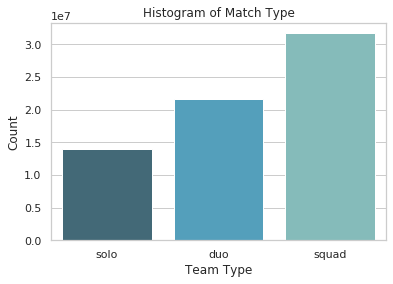

In [80]:
plot = sns.barplot(x="team type", y="counts", data=vc1_pd, palette="GnBu_d")
plot.set_title('Histogram of Match Type')
plot.set_xlabel('Team Type')
plot.set_ylabel('Count')
plt.show()

In [83]:
vc2 = hdf.cols['drive'].value_counts()
vc2_pd = vc2.rename_axis('drive').reset_index(name='counts')
vc2_pd

,drive,counts
0,0,39091658
1,1,28277573


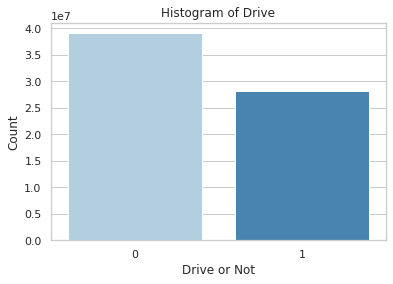

In [84]:
plot = sns.barplot(x="drive", y="counts", data=vc2_pd, palette="Blues")
plot.set_title('Histogram of Drive')
plot.set_xlabel('Drive or Not')
plot.set_ylabel('Count')
plt.show()

In [88]:
vc3 = hdf.cols['game_size_catg'].value_counts()
vc3_pd = vc3.rename_axis('game_size_catg').reset_index(name='counts')
vc3_pd = vc3_pd.sort_values('counts', ascending=False)
vc3_pd

,game_size_catg,counts
2,Small,31757079
1,Medium,21589580
0,Large,14022572


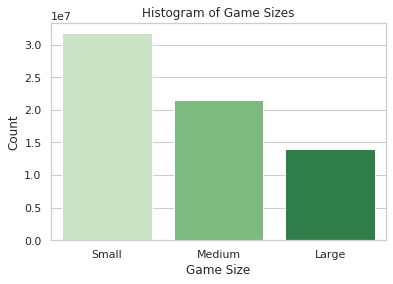

In [90]:
plot = sns.barplot(x="game_size_catg", y="counts", data=vc3_pd, palette="Greens")
plot.set_title('Histogram of Game Sizes')
plot.set_xlabel('Game Size')
plot.set_ylabel('Count')
plt.show()

## Number of Records for each Match Mode

In [202]:
hdf.cols['match_mode'].value_counts()

match_mode
tpp    67369231
Name: value_counts, dtype: int64

In [213]:
hdf.cols[['player_dmg', 'player_kills', 'player_dbno']].corr('pearson')

,player_dmg,player_kills,player_dbno
player_dmg,1.000000,0.899580,0.746404
player_kills,0.899580,1.000000,0.712759
player_dbno,0.746404,0.712759,1.000000


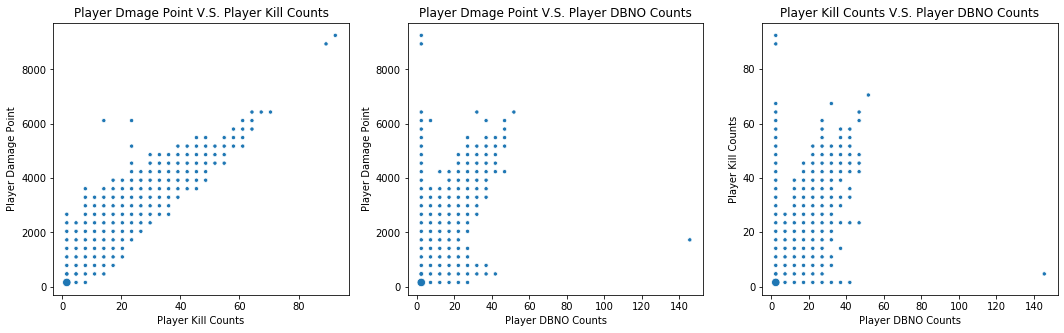

In [247]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

ax1 = hdf.cols[['player_kills', 'player_dmg']].scatterplot(ax=axs[0])
ax1.set_title('Player Dmage Point V.S. Player Kill Counts')
ax1.set_xlabel('Player Kill Counts')
ax1.set_ylabel('Player Damage Point')

ax2 = hdf.cols[['player_dbno', 'player_dmg']].scatterplot(ax=axs[1])
ax2.set_title('Player Dmage Point V.S. Player DBNO Counts')
ax2.set_xlabel('Player DBNO Counts')
ax2.set_ylabel('Player Damage Point')

ax3 = hdf.cols[['player_dbno', 'player_kills']].scatterplot(ax=axs[2])
ax3.set_title('Player Kill Counts V.S. Player DBNO Counts')
ax3.set_xlabel('Player DBNO Counts')
ax3.set_ylabel('Player Kill Counts')

plt.show()

(<Figure size 1800x720 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f926bd6c0b8>])

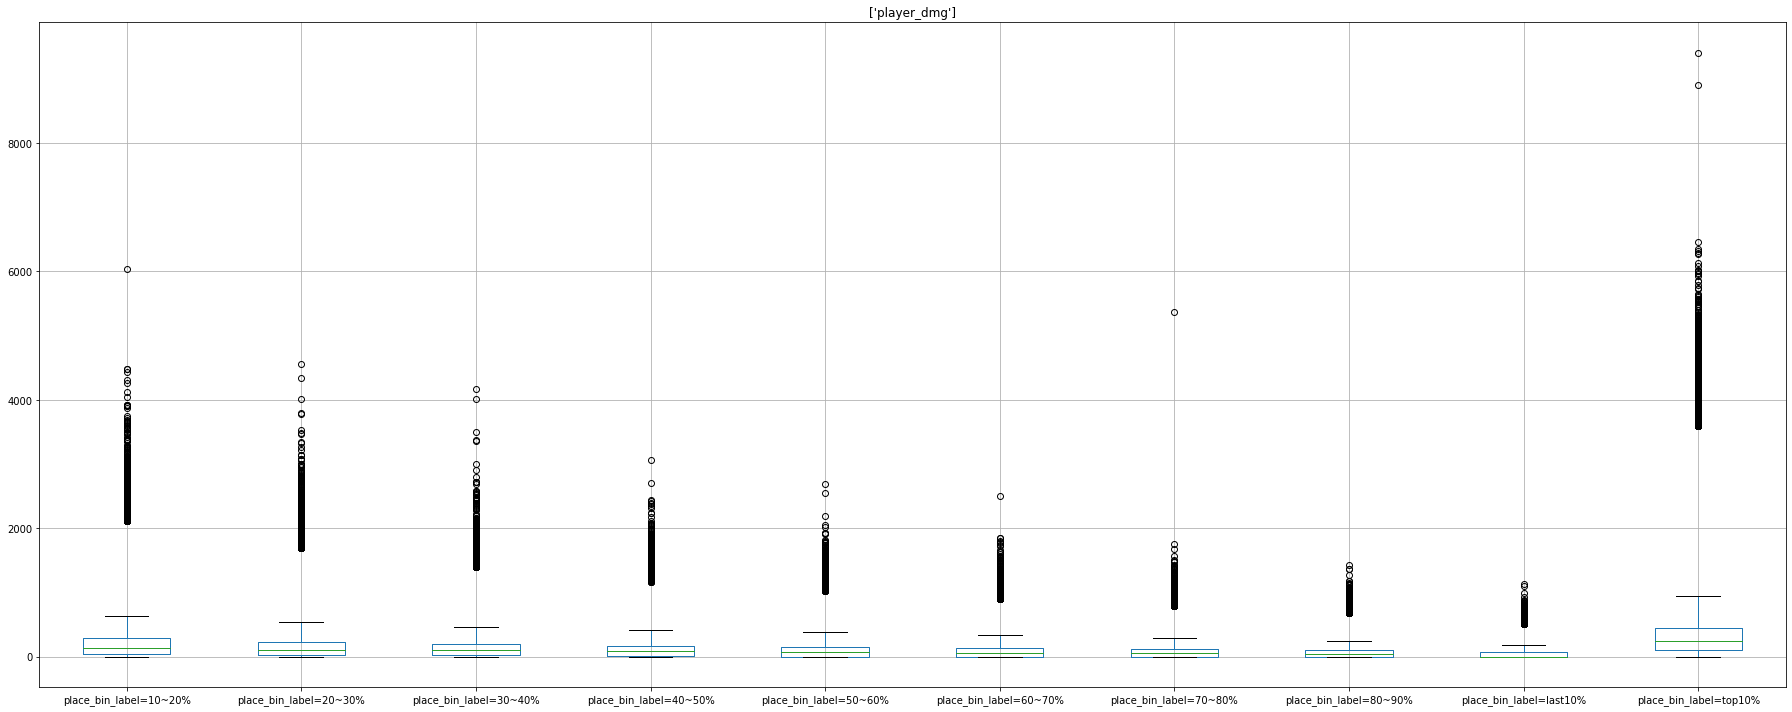

In [231]:
hdf.stratify(['place_bin_label']).cols[['player_dmg']].boxplot(figsize = (25, 10))

(<Figure size 1080x360 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f926b66de80>])

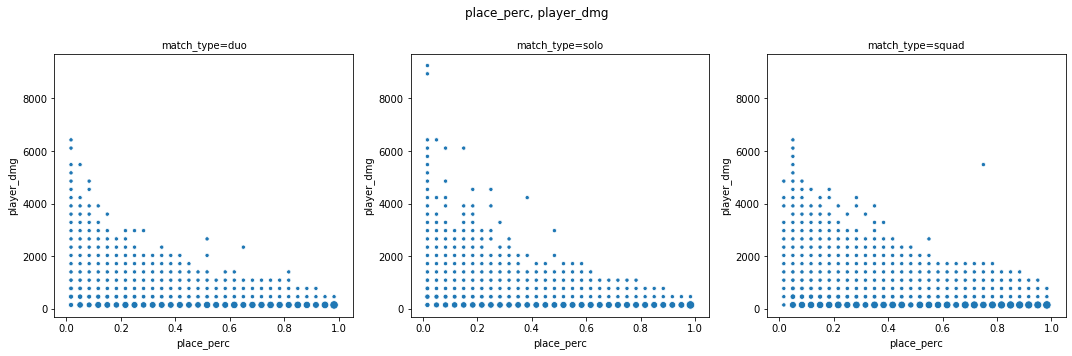

In [232]:
hdf.stratify(['match_type']).cols[['place_perc', 'player_dmg']].scatterplot(figsize = (15, 5))

(<Figure size 1800x720 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f926bfe7ba8>])

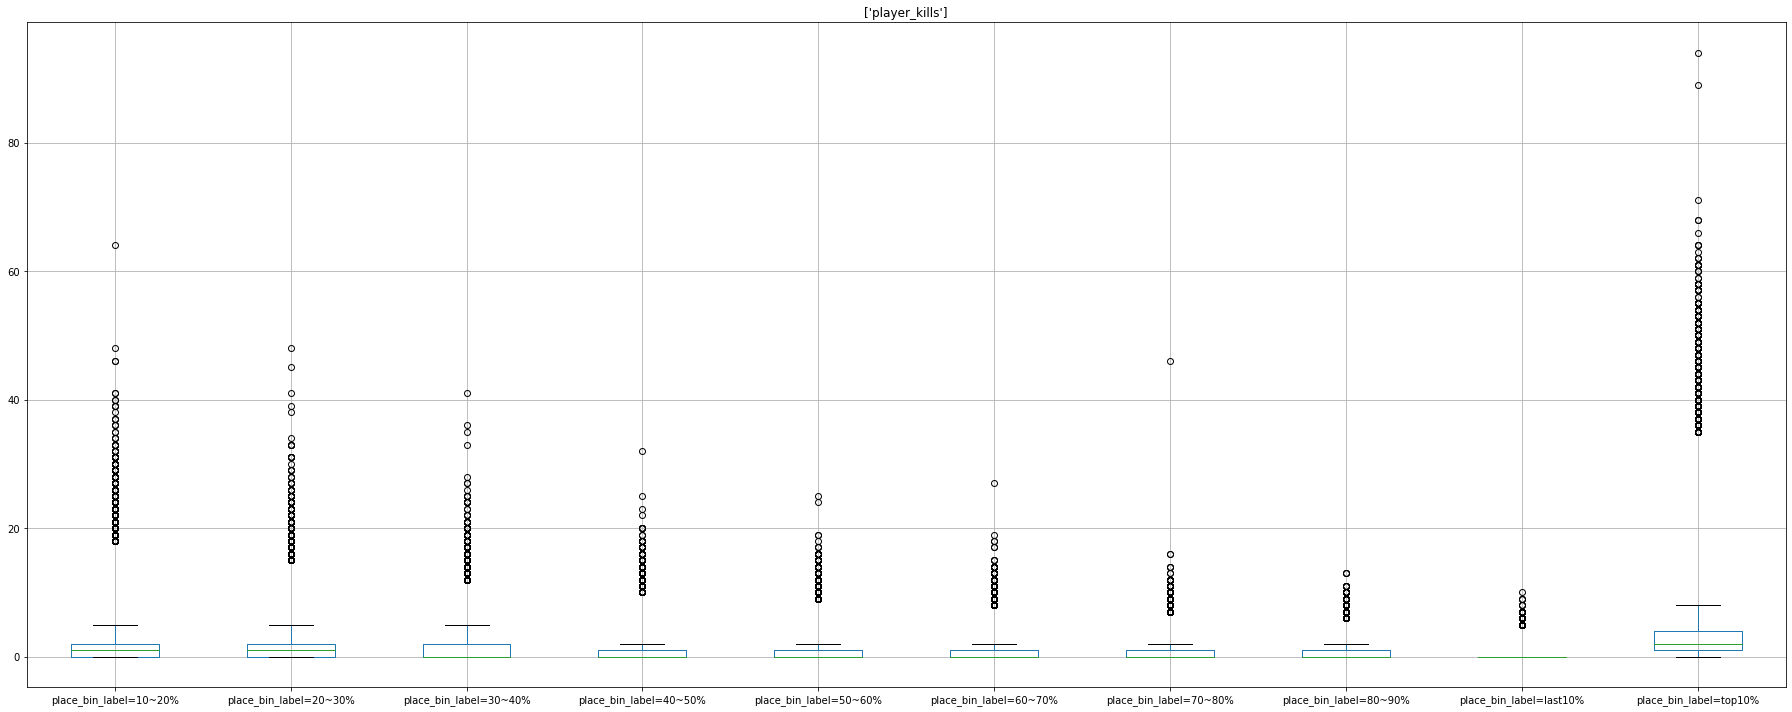

In [229]:
hdf.stratify(['place_bin_label']).cols[['player_kills']].boxplot(figsize = (25, 10))

(<Figure size 1080x360 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f926ca6d470>])

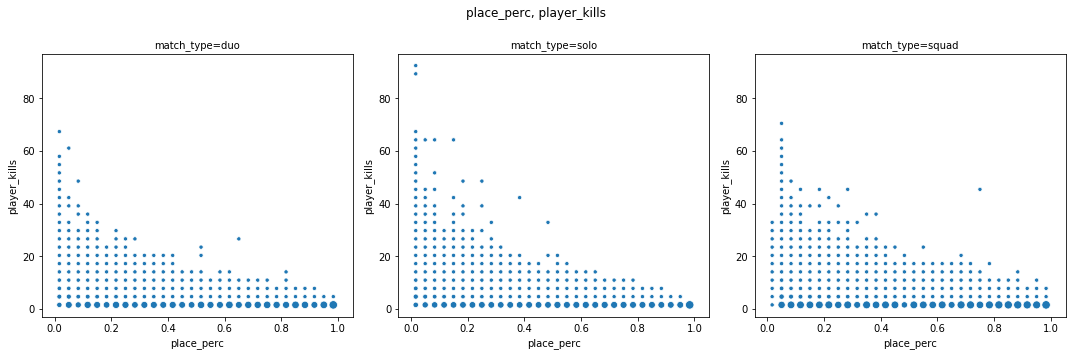

In [204]:
hdf.stratify(['match_type']).cols[['place_perc', 'player_kills']].scatterplot(figsize = (15, 5))

分析：solo中杀的越多成绩越好，duo同理但是因为人头数在队友间分散，杀人树max值较低，squad则不一定，杀得贼多的反而容易在决赛圈翻车，因为这种情况都是1带3的那种hhhh，而4人都强的那种人头分散，决赛圈4打1hhhh

In [207]:
hdf.stratify(['place_bin_label']).cols[['player_dist_ride']].q1()

place_bin_label
10~20%     338.581024
20~30%       2.599393
30~40%       0.000000
40~50%       0.000000
50~60%       0.000000
60~70%       0.000000
70~80%       0.000000
80~90%       0.000000
last10%      0.000000
top10%     807.061890
Name: player_dist_ride, dtype: float32

In [208]:
hdf.stratify(['place_bin_label']).cols[['player_dist_ride']].median()

place_bin_label
10~20%     2193.835693
20~30%     1830.664673
30~40%     1303.230225
40~50%      508.623444
50~60%        0.000000
60~70%        0.000000
70~80%        0.000000
80~90%        0.000000
last10%       0.000000
top10%     2573.577393
Name: player_dist_ride, dtype: float32

In [209]:
hdf.stratify(['place_bin_label']).cols[['player_dist_ride']].q3()

place_bin_label
10~20%     4030.455078
20~30%     3714.018066
30~40%     3197.841553
40~50%     2312.862549
50~60%     1171.307129
60~70%        0.000000
70~80%        0.000000
80~90%        0.000000
last10%       0.000000
top10%     4324.330566
Name: player_dist_ride, dtype: float32

(<Figure size 1800x720 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f926d19fcf8>])

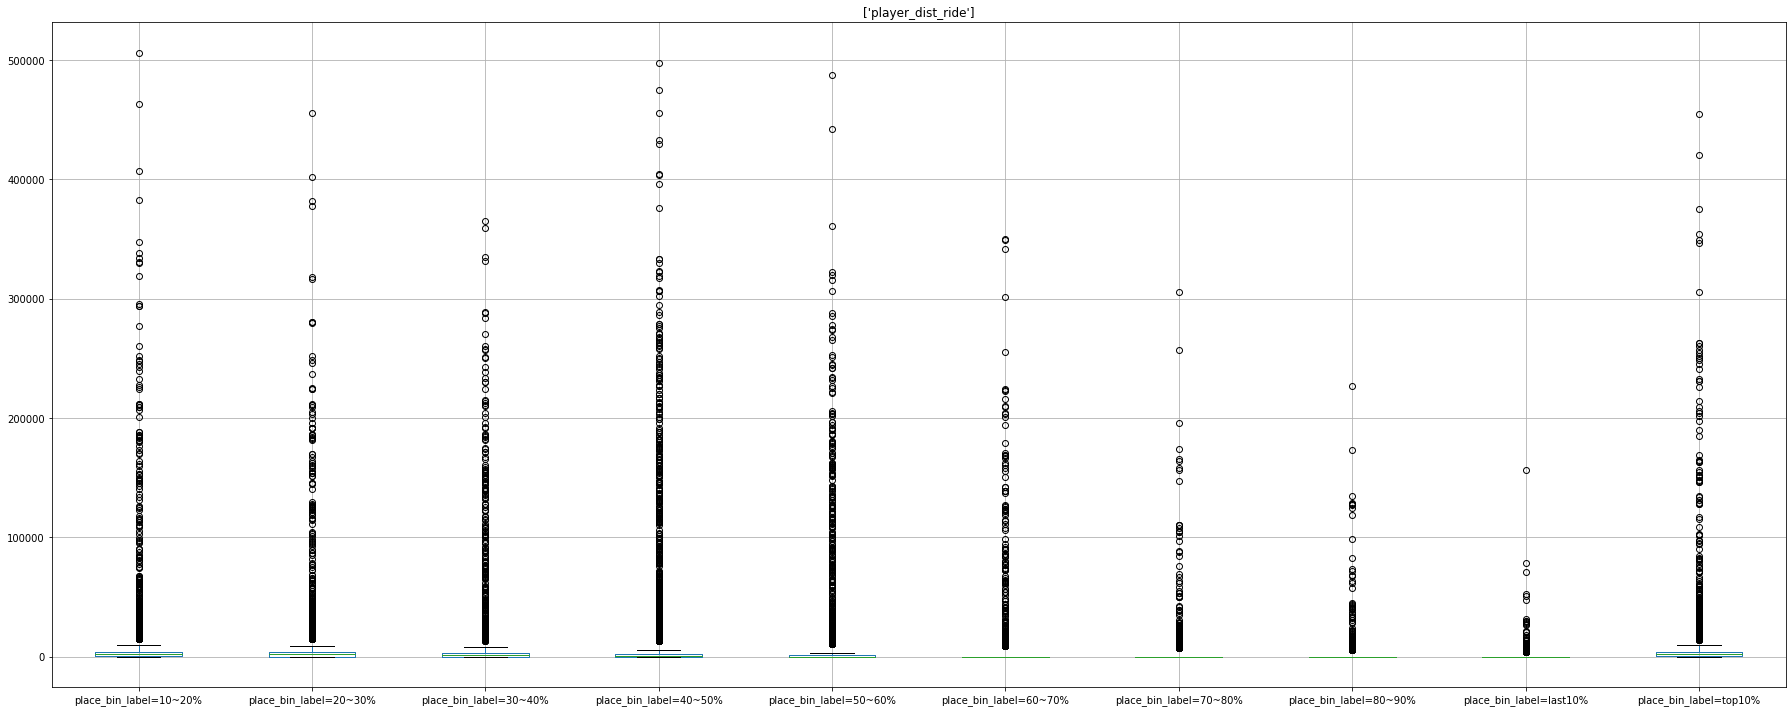

In [226]:
hdf2.stratify(['place_bin_label']).cols[['player_dist_ride']].boxplot(figsize = (25, 10))

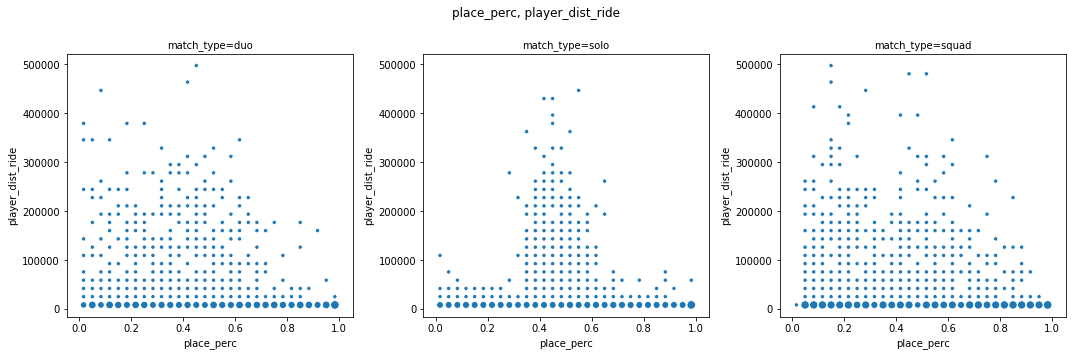

In [220]:
plot = hdf.stratify(['team_type']).cols[['place_perc', 'player_dist_ride']].scatterplot(figsize = (15, 5))

(<Figure size 1800x720 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f926c3bd898>])

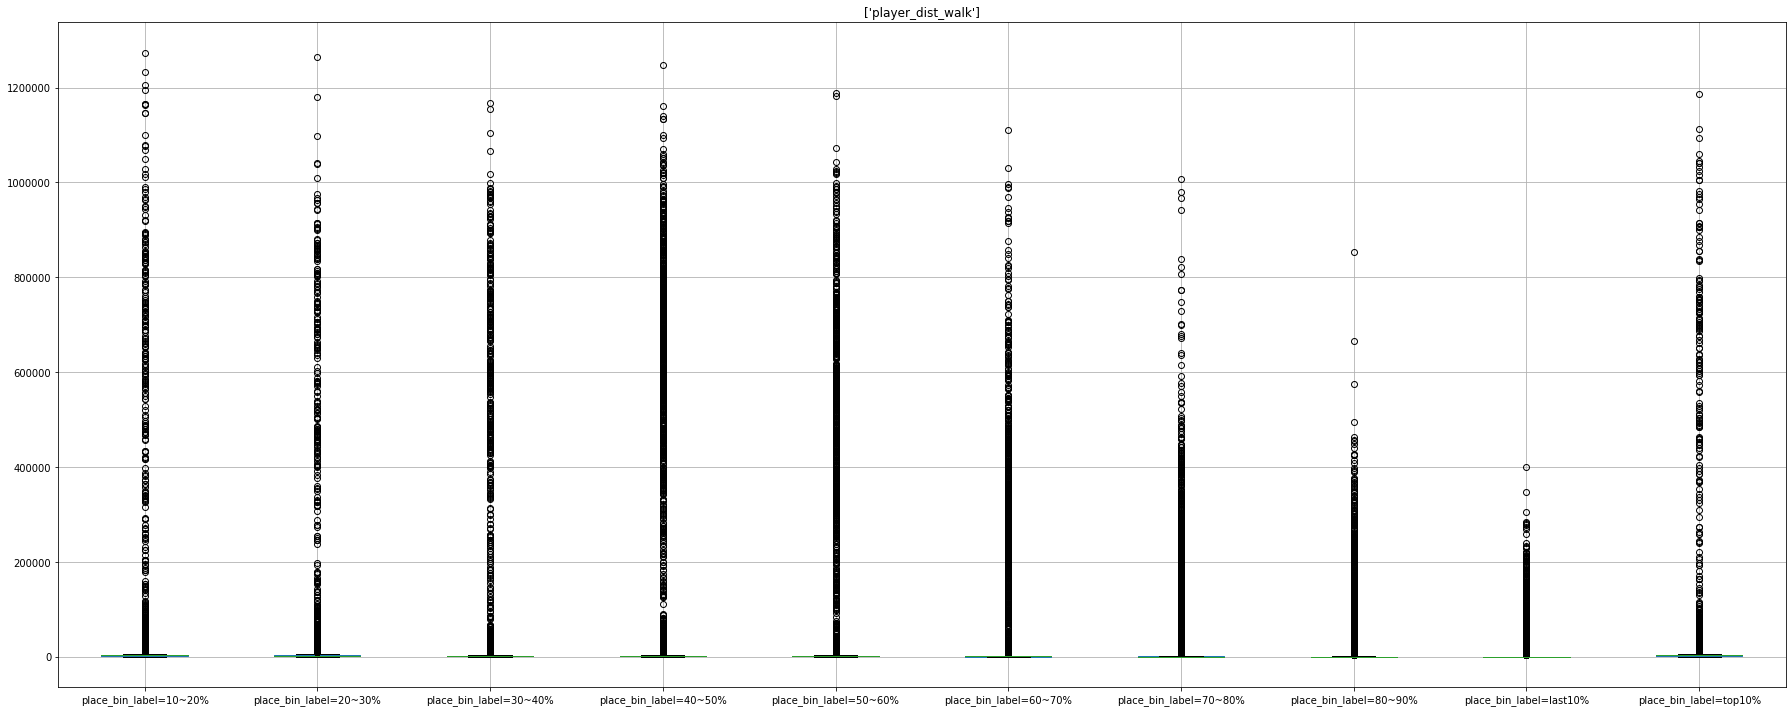

In [225]:
hdf2.stratify(['place_bin_label']).cols[['player_dist_walk']].boxplot(figsize = (25, 10))

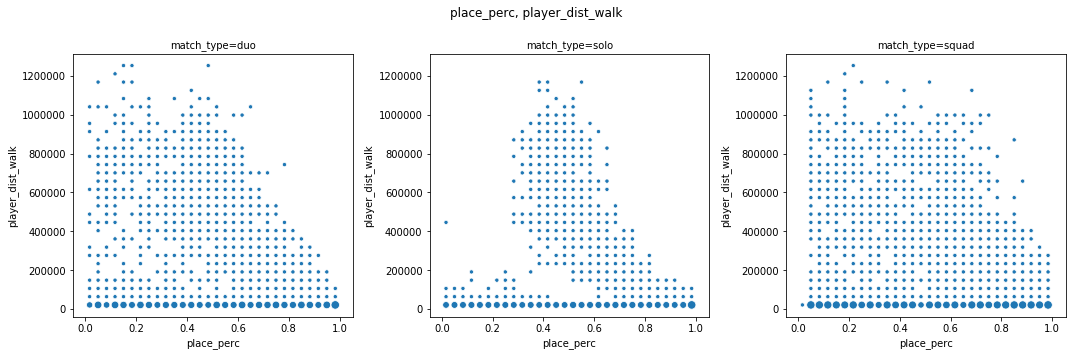

In [222]:
plot = hdf.stratify(['team_type']).cols[['place_perc', 'player_dist_walk']].scatterplot(figsize = (15, 5))

## Models

In [17]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [29]:
df_md1 = df.drop(*['game_size', 'place_bin', 'team_placement', 'player_count', 'place_bin_label', 'place_perc', 'drive'])

In [18]:
df_md2 = df.drop(*['game_size', 'top_5', 'team_placement', 'player_count', 'place_bin_label', 'place_perc', 'drive'])

In [31]:
df_md1.printSchema()

root
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: float (nullable = true)
 |-- player_dist_walk: float (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_survive_time: float (nullable = true)
 |-- team_type: string (nullable = false)
 |-- game_size_catg: string (nullable = false)
 |-- top_5: integer (nullable = false)



In [19]:
df_md2.printSchema()

root
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: float (nullable = true)
 |-- player_dist_walk: float (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_survive_time: float (nullable = true)
 |-- team_type: string (nullable = false)
 |-- place_bin: double (nullable = true)
 |-- game_size_catg: string (nullable = false)



In [107]:
# Split processed data into training set and test set
splitted_data1 = df_md1.randomSplit([0.8, 0.2], 24)
train_data1 = splitted_data1[0]
test_data1 = splitted_data1[1]

In [20]:
# Split processed data into training set and test set
splitted_data2 = df_md2.randomSplit([0.8, 0.2], 24)
train_data2 = splitted_data2[0]
test_data2 = splitted_data2[1]

In [21]:
stringIndexer_team_type = StringIndexer(inputCol="team_type", outputCol="team_type_IX", handleInvalid="keep")
stringIndexer_game_size = StringIndexer(inputCol="game_size_catg", outputCol="game_size_IX", handleInvalid="keep")
stringIndexer_top_5 = StringIndexer(inputCol="top_5", outputCol="label1", handleInvalid="keep")
stringIndexer_place_bin = StringIndexer(inputCol="place_bin", outputCol="label2", handleInvalid="keep")

In [22]:
vecAssembler_features = VectorAssembler(inputCols=["player_assists", 
                                                   "player_dist_ride",
                                                   "player_dist_walk",
                                                   "player_dmg",
                                                   "player_kills",
                                                   "player_survive_time",
                                                   "team_type_IX",
                                                   "game_size_IX"], 
                                        outputCol="features")

### Logistic Regression

In [110]:
lr1 = LogisticRegression(labelCol="label1", featuresCol="features", maxIter=10)

In [23]:
lr2 = LogisticRegression(labelCol="label2", featuresCol="features", maxIter=10, family="multinomial")

In [111]:
pipeline_lr1= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_top_5,
                              vecAssembler_features, 
                              lr1])

In [24]:
pipeline_lr2= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_place_bin,
                              vecAssembler_features, 
                              lr2])

In [114]:
%%time
model_lr1 = pipeline_lr1.fit(train_data1)

CPU times: user 208 ms, sys: 45.2 ms, total: 253 ms
Wall time: 2min 56s


In [25]:
%%time
model_lr2 = pipeline_lr2.fit(train_data2)

CPU times: user 204 ms, sys: 38 ms, total: 242 ms
Wall time: 7min 25s


In [116]:
%%time
import pyspark.mllib.evaluation as ev
# Make predictions on the test set and evaluate model performance
pred_lr1 = model_lr1.transform(test_data1)
pred_actual_lr1 = pred_lr1.rdd.map(lambda row: (row.prediction, float(row.top_5)))
metrics_lr1 = ev.BinaryClassificationMetrics(pred_actual_lr1)
print(f'Area under PR = {metrics_lr1.areaUnderPR}')
print(f'Area under ROC = {metrics_lr1.areaUnderROC}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Area under PR = 0.5254485257396244
Area under ROC = 0.6756874634343709


In [26]:
%%time
import pyspark.mllib.evaluation as ev
# Make predictions on the test set and evaluate model performance
pred_lr2 = model_lr2.transform(test_data2)
pred_actual_lr2 = pred_lr2.rdd.map(lambda row: (row.prediction, float(row.place_bin)))
metrics_lr2 = ev.MulticlassMetrics(pred_actual_lr2)
print(f'Precision = {metrics_lr2.precision()}')
print(f'F1 Score = {metrics_lr2.fMeasure()}')

Precision = 0.07349009431098774
F1 Score = 0.07349009431098774
CPU times: user 393 ms, sys: 39.2 ms, total: 432 ms
Wall time: 7min 21s


### Random Forest Classifier

In [117]:
rf1 = RandomForestClassifier(labelCol="label1", featuresCol="features", numTrees=10, maxDepth= 5, seed=24)

In [44]:
rf2 = RandomForestClassifier(labelCol="label2", featuresCol="features", numTrees=50, maxDepth= 5, seed=24)

In [118]:
pipeline_rf1= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_top_5,
                              vecAssembler_features, 
                              rf1])

In [28]:
pipeline_rf2= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_place_bin,
                              vecAssembler_features, 
                              rf2])

In [119]:
%%time
model_rf1 = pipeline_rf1.fit(train_data1)

CPU times: user 143 ms, sys: 21 ms, total: 164 ms
Wall time: 5min 37s


In [47]:
%%time
model_rf2 = pipeline_rf2.fit(train_data2)

CPU times: user 194 ms, sys: 41.2 ms, total: 235 ms
Wall time: 9min 6s


In [120]:
%%time
# Make predictions on the test set and evaluate model performance
pred_rf = model_rf.transform(test_data)
pred_actual_rf = pred_rf.rdd.map(lambda row: (row.prediction, float(row.top_5)))
metrics_rf = ev.BinaryClassificationMetrics(pred_actual_rf)
print(f'Area under PR = {metrics_rf.areaUnderPR}')
print(f'Area under ROC = {metrics_rf.areaUnderROC}')

Area under PR = 0.7668855763192157
Area under ROC = 0.8218243986274724
CPU times: user 55.2 ms, sys: 7.93 ms, total: 63.2 ms
Wall time: 3min 21s


In [51]:
%%time
import pyspark.mllib.evaluation as ev
# Make predictions on the test set and evaluate model performance
pred_rf2 = model_rf2.transform(test_data2)
evaluator_rf2 = MulticlassClassificationEvaluator(labelCol="label2", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy_rf2 = evaluator_rf2.evaluate(pred_rf2)

#pred_actual_rf2 = pred_rf2.rdd.map(lambda row: (row.prediction, float(row.place_bin)))
#metrics_rf2 = ev.MulticlassMetrics(pred_actual_rf2)
#print(f'Precision = {metrics_rf2.precision()}')
#print(f'F1 Score = {metrics_rf2.fMeasure()}')

CPU times: user 49.1 ms, sys: 14.3 ms, total: 63.4 ms
Wall time: 1min 42s


In [52]:
accuracy_rf2

0.4511358328468691

In [42]:
pred_actual_rf2.take(50)

[(0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 8.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 6.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0),
 (0.0, 9.0)]

### Gradient Boosting Trees/Machine

In [121]:
gbt1 = GBTClassifier(labelCol="label1", featuresCol="features", maxIter=10, maxDepth= 5,seed=24)

In [31]:
gbt2 = GBTClassifier(labelCol="label2", featuresCol="features", maxIter=10, maxDepth= 5,seed=24)

In [122]:
pipeline_gbt1= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_top_5,
                              vecAssembler_features, 
                              gbt1])

In [32]:
pipeline_gbt2= Pipeline(stages=[stringIndexer_team_type,
                              stringIndexer_game_size,
                              stringIndexer_place_bin,
                              vecAssembler_features, 
                              gbt2])

In [123]:
%%time
model_gbt1 = pipeline_gbt1.fit(train_data1)

CPU times: user 500 ms, sys: 123 ms, total: 623 ms
Wall time: 8min 27s


In [33]:
%%time
model_gbt2 = pipeline_gbt2.fit(train_data2)

Py4JJavaError: An error occurred while calling o888.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 67.0 failed 4 times, most recent failure: Lost task 0.3 in stage 67.0 (TID 3805, ip-172-31-54-180.ec2.internal, executor 5): java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 3.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:167)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:165)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2041)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2029)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2028)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2028)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:966)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:966)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:966)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2262)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2200)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:777)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1337)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:112)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:106)
	at org.apache.spark.ml.regression.DecisionTreeRegressor$$anonfun$train$2.apply(DecisionTreeRegressor.scala:129)
	at org.apache.spark.ml.regression.DecisionTreeRegressor$$anonfun$train$2.apply(DecisionTreeRegressor.scala:124)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:124)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:297)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:55)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1.apply(GBTClassifier.scala:206)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1.apply(GBTClassifier.scala:156)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:156)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 3.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:167)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:165)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [124]:
%%time
# Make predictions on the test set and evaluate model performance
pred_gbt = model_gbt.transform(test_data)
pred_actual_gbt = pred_gbt.rdd.map(lambda row: (row.prediction, float(row.top_5)))
metrics_gbt = ev.BinaryClassificationMetrics(pred_actual_gbt)
print(f'Area under PR = {metrics_gbt.areaUnderPR}')
print(f'Area under ROC = {metrics_gbt.areaUnderROC}')

Area under PR = 0.7677583522965933
Area under ROC = 0.8449178815705465
CPU times: user 81.6 ms, sys: 10.1 ms, total: 91.6 ms
Wall time: 7min 47s


In [34]:
%%time
import pyspark.mllib.evaluation as ev
# Make predictions on the test set and evaluate model performance
pred_gbt2 = model_gbt2.transform(test_data2)
pred_actual_gbt2 = pred_gbt2.rdd.map(lambda row: (row.prediction, float(row.place_bin)))
metrics_gbt2 = ev.MulticlassMetrics(pred_actual_gbt2)
print(f'Precision = {metrics_gbt2.precision()}')
print(f'F1 Score = {metrics_gbt2.fMeasure()}')

NameError: name 'model_gbt2' is not defined

In [125]:
evaluations = {'Area under PR': [metrics_lr.areaUnderPR, metrics_rf.areaUnderPR, metrics_gbt.areaUnderPR],
               'Area under ROC': [metrics_lr.areaUnderROC, metrics_rf.areaUnderROC, metrics_gbt.areaUnderROC]}

In [126]:
evaluations_pd = pd.DataFrame.from_dict(evaluations)
evaluations_pd=evaluations_pd.T

In [127]:
eva_idx = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Trees']
evaluations_pd.columns=eva_idx
evaluations_pd

,Logistic Regression,Random Forest,Gradient Boosting Trees
Area under PR,0.525449,0.766886,0.767758
Area under ROC,0.675687,0.821824,0.844918


In [207]:
spark.stop()